<a href="https://colab.research.google.com/github/vndee/pytorch-vi/blob/master/data_loading_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

#Data Loading and Processing Tutorial

**Author**: Sasank Chilamkurthy <https://chsasank.github.io>_

Một trong những vấn đề được đầu tư và bỏ công sức lớn trong việc giải quyết các bài toán học sâu đó là chuẩn bị dữ liệu. Do đó PyTorch cung cấp rất nhiều công cụ hỗ trợ cho việc load dữ liệu cũng xử lí dữ liệu một cách dễ dàng và trực quan. Trong bài này chúng ta sẽ tìm hiểu load và xử lý dữ liệu trong PyTorch thực sự hoạt động như thế nào.

Trước hết chúng ta cần cài một số package liên quan đến dữ liệu:
- `scikit-images`: Dùng để đọc và biến đổi ảnh.
- `pandas`:  Dùng để đọc file csv một cách dễ dàng.


In [0]:
import os
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from __future__ import print_function, division

# ignore warning
import warnings
warnings.filterwarnings('ignore')

# iteractive mode
plt.ion()

Chúng ta sẽ thử với một tập data `facial pose` tại địa chỉ: `<https://download.pytorch.org/tutorial/faces.zip>`. Tập data này được tạo từ `dlib's pose estimation <http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>` với một vài ảnh được gán nhãn "face" từ imagenet.
![alt text](https://pytorch.org/tutorials/_images/landmarked_face2.png)

In [0]:
!wget https://download.pytorch.org/tutorial/faces.zip && unzip faces.zip

Tập dữ liệu gồm vài tấm ảnh và một file csv với cấu trúc:
```
image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
0805personali01.jpg,27,83,27,98, ... 84,134
1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312
```
Dữ liệu kiểu này có thể dễ dàng đọc được bằng pandas. Chúng ta sử dụng pandas để đọc dữ liệu vào một mảng (N, 2) với N là số lượng landmark.

In [3]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


Bây giờ chúng ta có thể viết một hàm đơn giản để hiển thị một vài ảnh cùng với landmark của nó để xem dữ liệu thực sự như thế nào.

In [0]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

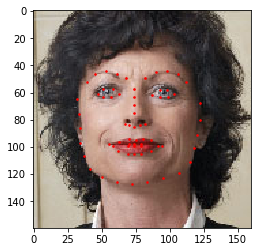

In [5]:
plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)), landmarks)
plt.show()

## Lớp Dataset
`torch.utils.data.Dataset` là một abstract class thể hiện tập dữ liệu của PyTorch. Tất cả các tập dữ liệu của chúng ta nên kế thừa lớp này và override các phương thức sau:
- `__len__`: kích thước tập dữ liệu.
- `__getitem__`: dùng để truy xuất dữ liệu theo index như kiểu dữ liệu danh sách (ví dụ `dataset[i]`.

Chúng ta sẽ tạo một lớp `FaceLandmarksDataset` để lưu tập dữ liệu như đã nói đến ở trên. `FaceLandmarksDataset` sẽ đọc dữ liệu từ file csv. `FaceLandmarkDataset` sẽ được truyền vào tham số là đường dẫn đến file csv ở phương thức `__init__`, tuy nhiên việc đọc từng ảnh lên sẽ nằm ở phương thức `__getitem__`. Việc này sẽ giúp chương trình tiết kiệm bộ nhớ khá nhiều, trong rất nhiều chương trình huấn luyện các thuật toán học sâu, việc đọc lên một lần hết toàn bộ tập dữ liệu là một việc không nên. 

In [0]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

Khởi tạo đối tượng `face_dataset` thuộc class `FaceLandmarksDataset` và in ra 4 mẫu dữ liệu từ đối tượng `face_dataset`.

0 (324, 215, 3) (68, 2)


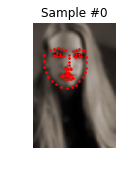

1 (500, 333, 3) (68, 2)


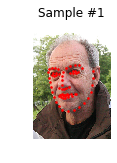

2 (250, 258, 3) (68, 2)


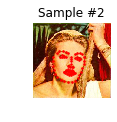

3 (434, 290, 3) (68, 2)


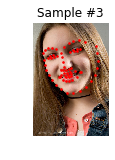

In [7]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

##Transforms
Như đã in ra ở trên, dễ dàng nhận thấy kích thước của các tấm ảnh là không giống nhau. Vì vậy chúng ta cần một vài bước tiền xử lí để khiến cho kích thước của từng mẫu dữ liệu là giống nhau. Chúng ta sẽ tạo 3 transforms (biến đổi).
- `Rescale`: Dùng để thu nhỏ hay phóng to ảnh về một kích thước xác định.
- `RandomCrop`: Để cắt hình ảnh ngẫu nhiên. Đây có thể coi là làm gia tăng dữ liệu (data augmentation).
- `ToTensor`: Để convert mảng numpy sang torch tensor.

Các biến đổi này sẽ được viết bằng một lớp có thể gọi được (callable class) thay vì một hàm. Việt này sẽ giúp tiết kiệm số lần truyền tham số vì các tham số chỉ cần truyền vào một lần thay vì phải truyền vào mỗi lần gọi hàm. Chúng ta có thể dùng các kiểu biến đổi như sau:
```
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```

In [0]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

##Biến đổi và đồng bộ tập dữ liệu
Dùng các class đã định nghĩa để đưa hình ảnh về kích thước (256, 256) và cắt ngẫu nhiên một ảnh (254, 254) từ ảnh đó. Chúng ta cần kết hợp cả `Rescale` và `RandomCrop`. `torchvision.transforms.Compose` cho phép chúng ta làm điều đó một cách dễ dàng.

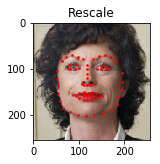

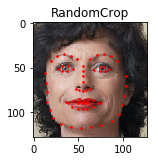

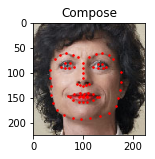

In [9]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

##Duyệt toàn bộ tập dữ liệu
Bây giờ chúng ta duyệt toàn bộ tập dữ liệu và thực hiện các thao tác biến đổi với tập dữ liệu đó. Một cách tổng quát, tại mỗi bước:
- Đọc vào một ảnh từ đường dẫn.
- Các phép biến đổi kết hợp sẽ được áp dụng lên ảnh được đọc vào.
- Bời vì một trong biến đổi là random (ngẫu nhiên) cắt một ảnh để tạo một mẫu dữ liệu mới, cho nên dữ liệu đã được gia tăng thêm khá nhiều.


In [10]:
transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


Tuy nhiên thay vì duyệt tuần tự từng ảnh, trong học sâu người ta thường dùng duyệt mỗi lần một batch of data đồng thời cũng shuffle data.
`torch.utils.data.DataLoader` là một iterator chưa tất cả các tiện ích như:
- Batching data.
- Shuffling data.
- Đọc dữ liệu song song bằng `multiprocessing`.


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


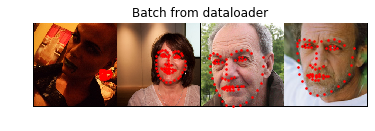

In [13]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

##`torchvision`
Đến đây chúng ta sẽ biết được cách đọc, ghi, biến đổi dữ liệu. Gói `torchvision` chứa một số kiểu định dạng dữ liệu phổ biến cũng như các phép biến đổi thông dụng. Lập trình viên thậm chí không cần tự viết một lớp nào. Một trong số đó là `ImageFolder`, giả sử chúng ta có một tập dữ liệu được tổ chức như sau:
```
root/ants/xxx.png
root/ants/xxy.jpeg
root/ants/xxz.png
.
.
.
root/bees/123.jpg
root/bees/nsdf3.png
root/bees/asd932_.png
```
Với `ants`, `bees`, .. là tên nhãn của ảnh. Khi đó làm việc với tập dữ liệu này sẽ nhẹ nhành hơn bằng việc dùng các lớp có sẵn trong `torchvision`.

In [0]:
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                           transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                             batch_size=4, shuffle=True,
                                             num_workers=4)